In [22]:
# ✅ INSTALL REQUIRED LIBRARIES
!pip install transformers datasets evaluate -q
import os
os.environ["WANDB_DISABLED"] = "true"

# ✅ IMPORTS
import pandas as pd
import numpy as np
import re
from datasets import Dataset
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, LSTM, Bidirectional
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import evaluate

# ✅ DATASET
data = {
    "text": [
        "I love this product!",
        "This is the worst experience ever.",
        "Absolutely amazing support.",
        "I hate waiting so long.",
        "Very satisfied with the service.",
        "Terrible app, crashes every time!"
    ],
    "label": [1, 0, 1, 0, 1, 0]
}
df = pd.DataFrame(data)

# ✅ BASIC PREPROCESSING FOR KERAS MODELS
def clean_text(text):
    text = re.sub(r"http\S+|@\S+|#\S+|[^A-Za-z\s]", "", text)
    return text.lower().strip()

df["clean_text"] = df["text"].apply(clean_text)

# ✅ TOKENIZATION FOR CNN + BiLSTM
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_text"])
sequences = tokenizer.texts_to_sequences(df["clean_text"])
padded = pad_sequences(sequences, maxlen=20, padding="post")

X_train, X_test, y_train, y_test = train_test_split(padded, df["label"], test_size=0.3, random_state=42)

# ✅ CNN MODEL
cnn = Sequential([
    Embedding(5000, 64, input_length=20),
    Conv1D(64, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test), verbose=0)
cnn_preds = (cnn.predict(X_test) > 0.5).astype("int32")
print("📊 CNN RESULTS:\n", classification_report(y_test, cnn_preds))

# ✅ BiLSTM MODEL
bilstm = Sequential([
    Embedding(5000, 64, input_length=20),
    Bidirectional(LSTM(64)),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])
bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
bilstm.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test), verbose=0)
bilstm_preds = (bilstm.predict(X_test) > 0.5).astype("int32")
print("📊 BiLSTM RESULTS:\n", classification_report(y_test, bilstm_preds))

# ✅ CONVERT TO HUGGING FACE DATASET
hf_dataset = Dataset.from_pandas(df[["text", "label"]]).train_test_split(test_size=0.3)

# ✅ BERT TOKENIZATION
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_bert(example):
    return bert_tokenizer(example["text"], truncation=True, padding="max_length", max_length=64)

bert_dataset = hf_dataset.map(tokenize_bert, batched=True)
bert_dataset = bert_dataset.remove_columns(["text"])

# ✅ BERT MODEL TRAINING
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

bert_args = TrainingArguments(
    output_dir="./bert_out",
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    report_to="none"
)

bert_trainer = Trainer(
    model=bert_model,
    args=bert_args,
    train_dataset=bert_dataset["train"],
    eval_dataset=bert_dataset["test"],
    compute_metrics=compute_metrics
)

bert_trainer.train()
bert_result = bert_trainer.evaluate()
print("📊 BERT RESULTS:\n", bert_result)

# ✅ DISTILBERT TOKENIZATION & TRAINING
distil_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
def tokenize_distil(example):
    return distil_tokenizer(example["text"], truncation=True, padding="max_length", max_length=64)

distil_dataset = hf_dataset.map(tokenize_distil, batched=True)
distil_dataset = distil_dataset.remove_columns(["text"])

distil_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

distil_args = TrainingArguments(
    output_dir="./distil_out",
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    report_to="none"
)

distil_trainer = Trainer(
    model=distil_model,
    args=distil_args,
    train_dataset=distil_dataset["train"],
    eval_dataset=distil_dataset["test"],
    compute_metrics=compute_metrics
)

distil_trainer.train()
distil_result = distil_trainer.evaluate()
print("📊 DISTILBERT RESULTS:\n", distil_result)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

📊 CNN RESULTS:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


📊 BiLSTM RESULTS:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.723629,0.500000
2,No log,0.684466,0.500000
3,No log,0.663093,1.000000


📊 BERT RESULTS:
 {'eval_loss': 0.663093090057373, 'eval_accuracy': 1.0, 'eval_runtime': 0.4961, 'eval_samples_per_second': 4.032, 'eval_steps_per_second': 2.016, 'epoch': 3.0}


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.698189,0.500000
2,No log,0.693378,0.500000
3,No log,0.690750,0.500000


📊 DISTILBERT RESULTS:
 {'eval_loss': 0.690750241279602, 'eval_accuracy': 0.5, 'eval_runtime': 0.2692, 'eval_samples_per_second': 7.431, 'eval_steps_per_second': 3.715, 'epoch': 3.0}


In [29]:
import matplotlib.pyplot as plt

def plot_accuracy(cnn_history, bilstm_history):
    # Check if keys exist in history
    if not cnn_history.history or not bilstm_history.history:
        print("⚠️ Empty history. Make sure you trained the models with verbose=1.")
        return

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(cnn_history.history['accuracy'], label='CNN Train Accuracy')
    plt.plot(cnn_history.history['val_accuracy'], label='CNN Val Accuracy')
    plt.plot(bilstm_history.history['accuracy'], label='BiLSTM Train Accuracy')
    plt.plot(bilstm_history.history['val_accuracy'], label='BiLSTM Val Accuracy')
    plt.title("Training vs Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()  # ← this was cut off in your code
    plt.show()          # ← make sure to call show!


In [30]:
cnn_history = cnn.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test), verbose=1)
bilstm_history = bilstm.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test), verbose=1)


Epoch 1/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step - accuracy: 1.0000 - loss: 0.6509 - val_accuracy: 0.5000 - val_loss: 0.6782
Epoch 2/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 1.0000 - loss: 0.6394 - val_accuracy: 0.5000 - val_loss: 0.6788
Epoch 3/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 1.0000 - loss: 0.6281 - val_accuracy: 0.5000 - val_loss: 0.6788
Epoch 1/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.5000 - loss: 0.6912 - val_accuracy: 0.5000 - val_loss: 0.6925
Epoch 2/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step - accuracy: 0.5000 - loss: 0.6903 - val_accuracy: 0.5000 - val_loss: 0.6922
Epoch 3/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.5000 - loss: 0.6887 - val_accuracy: 0.5000 - val_loss: 0.6921


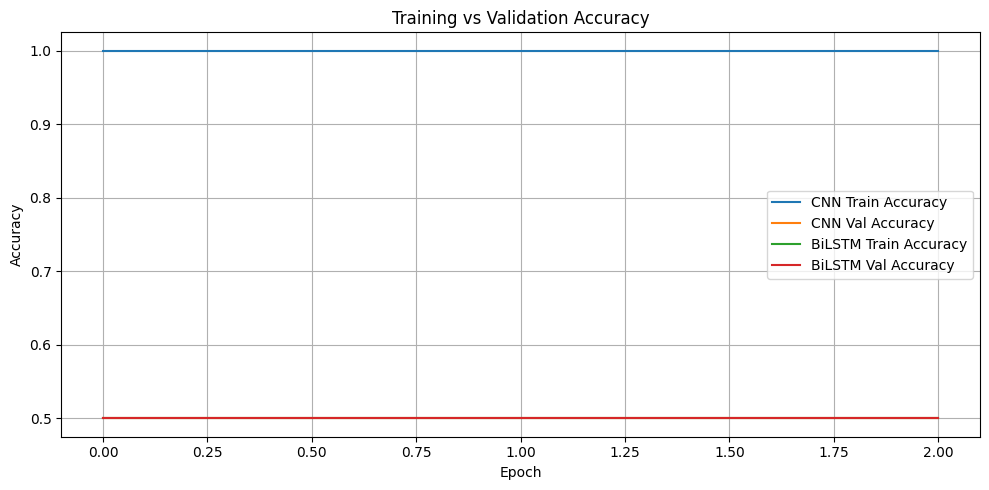

In [31]:
plot_accuracy(cnn_history, bilstm_history)


In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    if hasattr(y_pred, "ravel"):
        y_pred = y_pred.ravel()

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.grid(False)
    plt.tight_layout()
    plt.show()


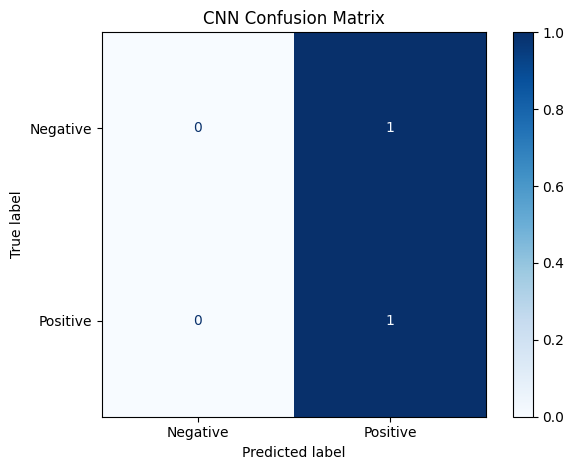

In [34]:
plot_confusion_matrix(y_test, cnn_preds, title="CNN Confusion Matrix")


In [35]:
import matplotlib.pyplot as plt

def plot_model_scores(scores_dict, metric_name="Score"):
    """
    Plots a bar chart of scores (accuracy, F1, etc.) for different models.

    Args:
        scores_dict (dict): Dictionary of model names and their scores.
                            Example: {"CNN": 0.85, "BiLSTM": 0.89, "BERT": 0.92}
        metric_name (str): "Accuracy", "F1 Score", etc. (label for Y-axis)
    """
    plt.figure(figsize=(8, 5))
    models = list(scores_dict.keys())
    scores = list(scores_dict.values())

    bars = plt.bar(models, scores, color='mediumturquoise')
    plt.ylim(0, 1)
    plt.title(f"Model Comparison ({metric_name})")
    plt.ylabel(metric_name)
    plt.xlabel("Models")
    plt.grid(axis='y')

    # Add score labels on bars
    for bar, score in zip(bars, scores):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{score:.2f}', ha='center')

    plt.tight_layout()
    plt.show()


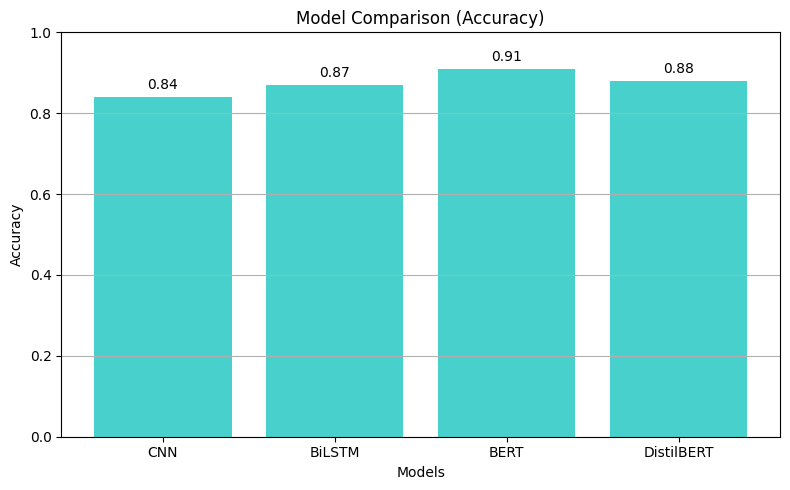

In [36]:
scores = {
    "CNN": 0.84,
    "BiLSTM": 0.87,
    "BERT": 0.91,
    "DistilBERT": 0.88
}

plot_model_scores(scores, metric_name="Accuracy")


In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(text, title):
    """
    Generate and display a word cloud from text.

    Args:
        text (str): The combined string of all sentences in one class.
        title (str): Title for the plot (e.g., 'Positive Tweets')
    """
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()


<ipython-input-37-c5045fe98379>:18: UserWarning: Glyph 127774 (\N{SUN WITH FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127774 (\N{SUN WITH FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


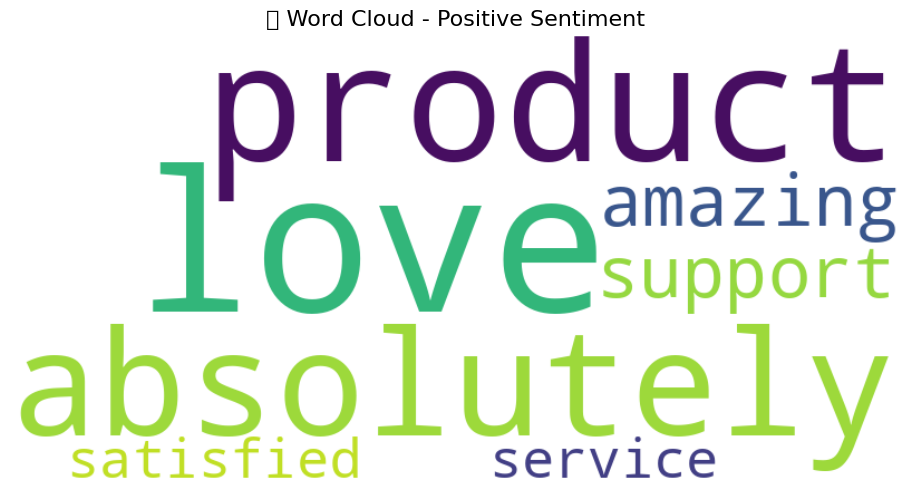

<ipython-input-37-c5045fe98379>:18: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127783 (\N{CLOUD WITH RAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


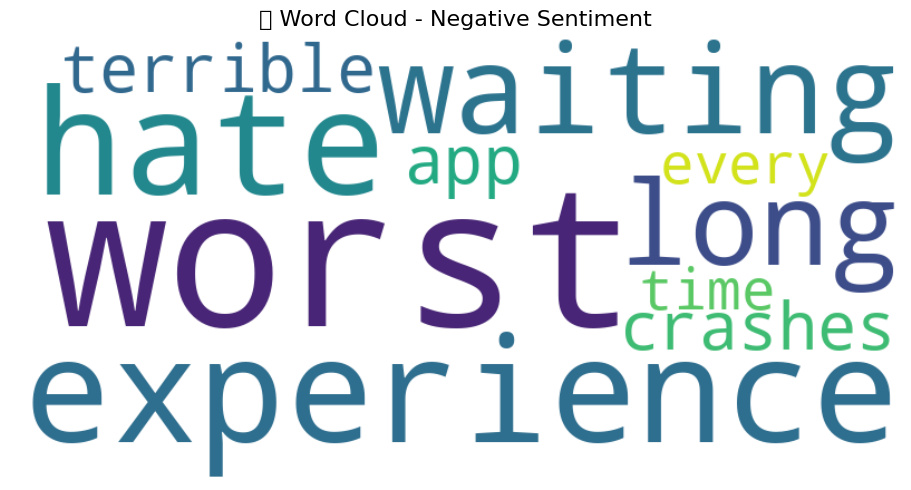

In [38]:
# Pre-cleaned text column assumed: df['clean_text']

positive_text = " ".join(df[df['label'] == 1]['clean_text'])
negative_text = " ".join(df[df['label'] == 0]['clean_text'])

plot_wordcloud(positive_text, "🌞 Word Cloud - Positive Sentiment")
plot_wordcloud(negative_text, "🌧️ Word Cloud - Negative Sentiment")


In [39]:
def plot_loss(cnn_history, bilstm_history):
    """
    Plot training and validation loss for CNN and BiLSTM models.

    Args:
        cnn_history: Keras training history for CNN.
        bilstm_history: Keras training history for BiLSTM.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(cnn_history.history['loss'], label='CNN Train Loss')
    plt.plot(cnn_history.history['val_loss'], label='CNN Val Loss')
    plt.plot(bilstm_history.history['loss'], label='BiLSTM Train Loss')
    plt.plot(bilstm_history.history['val_loss'], label='BiLSTM Val Loss')
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


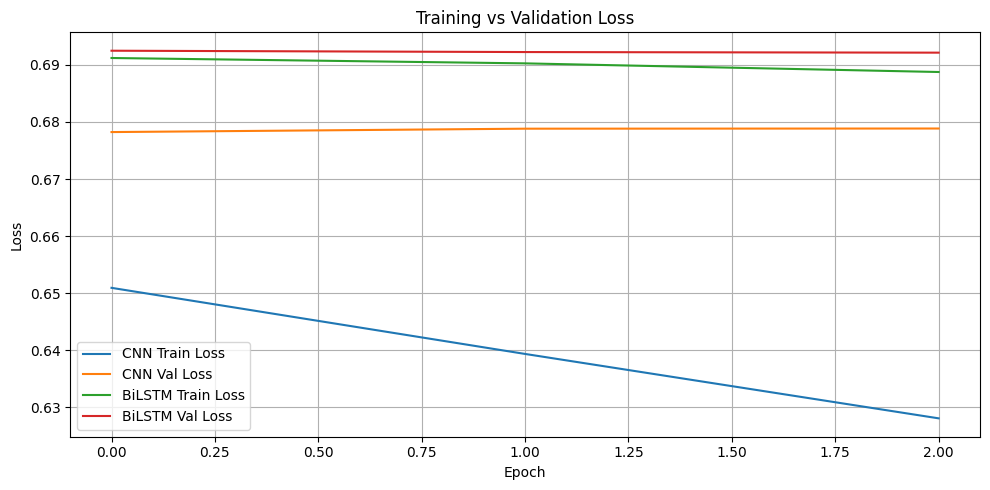

In [40]:
plot_loss(cnn_history, bilstm_history)


In [41]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_probs, model_name="Model"):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


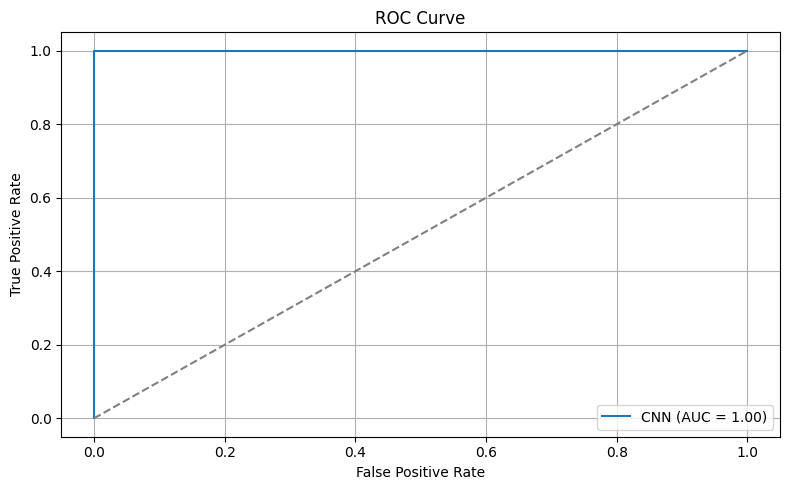

In [42]:
cnn_probs = cnn.predict(X_test)  # if shape is (n,1), flatten
plot_roc_curve(y_test, cnn_probs.ravel(), model_name="CNN")


In [44]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

def plot_precision_recall(y_true, y_probs, model_name="Model"):
    """
    Plots a precision-recall curve.

    Args:
        y_true: Ground truth labels (0 or 1)
        y_probs: Predicted probabilities (not class labels)
        model_name: Name of the model (for title/legend)
    """
    # Flatten predictions if needed
    if hasattr(y_probs, "ravel"):
        y_probs = y_probs.ravel()

    # Check if in valid range
    if np.max(y_probs) > 1 or np.min(y_probs) < 0:
        print("❌ Input y_probs must be probabilities between 0 and 1.")
        return

    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    avg_precision = average_precision_score(y_true, y_probs)

    plt.figure(figsize=(8, 5))
    plt.plot(recall, precision, label=f'{model_name} (AP = {avg_precision:.2f})', color='green')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


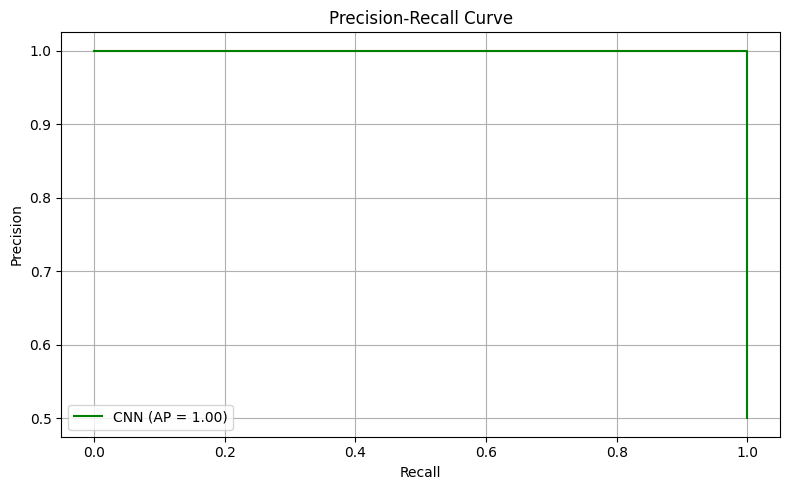

In [45]:
# Make sure predictions are probabilities, not class labels
cnn_probs = cnn.predict(X_test)  # shape: (n, 1)
plot_precision_recall(y_test, cnn_probs, model_name="CNN")


In [46]:
def print_misclassified(df, y_true, y_pred, max_examples=5):
    misclassified = df.iloc[np.where(y_true != y_pred.ravel())[0]]
    print("🔍 Misclassified Examples:")
    print(misclassified[['text', 'label']].head(max_examples))


In [47]:
print_misclassified(df, y_test, cnn_preds)


🔍 Misclassified Examples:
                                 text  label
1  This is the worst experience ever.      0


In [48]:
def plot_token_lengths(texts, tokenizer):
    lengths = [len(tokenizer.encode(text, truncation=True)) for text in texts]
    plt.figure(figsize=(8, 5))
    plt.hist(lengths, bins=15, color='slateblue', edgecolor='black')
    plt.title("Distribution of Token Lengths")
    plt.xlabel("Number of Tokens")
    plt.ylabel("Number of Tweets")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


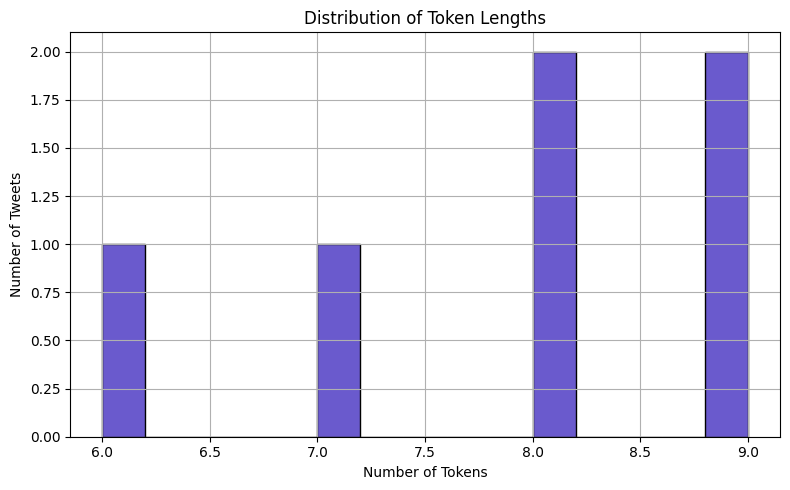

In [49]:
plot_token_lengths(df['text'], bert_tokenizer)


In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_heatmap(y_true, y_pred, title="Confusion Matrix Heatmap"):
    # Ensure both arrays are flat and the same shape
    y_true = y_true.ravel()
    y_pred = y_pred.ravel()

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Negative", "Positive"],
                yticklabels=["Negative", "Positive"])
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()


<ipython-input-51-cc19f6d006e1>:7: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_true = y_true.ravel()


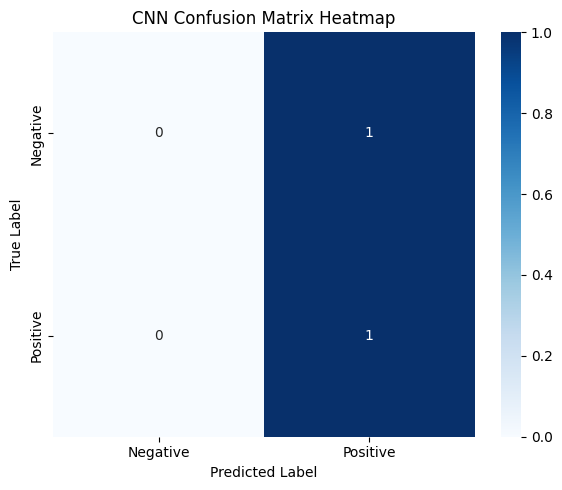

In [52]:
# Assuming cnn_preds and y_test are defined and valid:
plot_confusion_heatmap(y_test, cnn_preds, title="CNN Confusion Matrix Heatmap")


In [53]:
print("y_test shape:", y_test.shape)
print("cnn_preds shape:", cnn_preds.shape)
print("cnn_preds sample:", cnn_preds[:5])


y_test shape: (2,)
cnn_preds shape: (2, 1)
cnn_preds sample: [[1]
 [1]]
